In [1]:
!pip install cmake gym scipy

DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.


In [6]:
import pandas as pd
import seaborn as sns

In [8]:
import sys
from contextlib import closing
from io import StringIO
from gym import utils
from gym.envs.toy_text import discrete
import numpy as np

MAP = [
    "+---------------+",
    "| : : : : : : : |",
    "| : : : : : : : |",
    "| : :R: | : :G: |",
    "| : : : | : : : |",
    "| : : : : : : : |",
    "| : : | : | : : |",
    "| : :Y| : |B: : |",
    "| : : : : : : : |",
    "+---------------+",
]


# taxi_row, taxi_col, pass_idx, dest_idx = 3, 
# taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)


class TaxiEnv(discrete.DiscreteEnv):
    """
    The Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich
    Description:
    There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.
    Observations:
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. 
    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi
    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    Actions:
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger
    Rewards:
    There is a default per-step reward of -1,
    except for delivering the passenger, which is +20,
    or executing "pickup" and "drop-off" actions illegally, which is -10.
    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (R, G, Y and B): locations for passengers and destinations
    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)
    """
    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self):
        self.desc = np.asarray(MAP, dtype='c')

        self.locs = locs = [(0, 0), (0, 4), (4, 0), (4, 3)]

        num_states = 1280
        num_rows = 8
        num_columns = 8
        max_row = num_rows - 1
        max_col = num_columns - 1
        initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        P = {state: {action: []
                     for action in range(num_actions)} for state in range(num_states)}
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside taxi
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx < 4 and pass_idx != dest_idx:
                            initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = -1  # default reward when there is no pickup/dropoff
                            done = False
                            taxi_loc = (row, col)

                            if action == 0:
                                new_row = min(row + 1, max_row)
                            elif action == 1:
                                new_row = max(row - 1, 0)
                            if action == 2 and self.desc[1 + row, 2 * col + 2] == b":":
                                new_col = min(col + 1, max_col)
                            elif action == 3 and self.desc[1 + row, 2 * col] == b":":
                                new_col = max(col - 1, 0)
                            elif action == 4:  # pickup
                                if (pass_idx < 4 and taxi_loc == locs[pass_idx]):
                                    new_pass_idx = 4
                                else:  # passenger not at location
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (taxi_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    done = True
                                    reward = 20
                                elif (taxi_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(taxi_loc)
                                else:  # dropoff at wrong location
                                    reward = -10
                            new_state = self.encode(
                                new_row, new_col, new_pass_idx, dest_idx)
                            P[state][action].append(
                                (1.0, new_state, reward, done))
        initial_state_distrib /= initial_state_distrib.sum()
        discrete.DiscreteEnv.__init__(
            self, num_states, num_actions, P, initial_state_distrib)

    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 8
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 8)
        i = i // 8
        out.append(i)
        assert 0 <= i < 8
        return reversed(out)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x): return "_" if x == " " else x
        if pass_idx < 4:
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                out[1 + taxi_row][2 * taxi_col + 1], 'yellow', highlight=True)
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(out[1 + pi][2 * pj + 1], 'blue', bold=True)
        else:  # passenger in taxi
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                ul(out[1 + taxi_row][2 * taxi_col + 1]), 'green', highlight=True)

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], 'magenta')
        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["South", "North", "East", "West", "Pickup", "Dropoff"][self.lastaction]))
        else:
            outfile.write("\n")

        # No need to return anything for human
        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()
            
#     def update_map(self):
#         taxi_row, taxi_col, pass_idx, dest_idx = env.decode(self.s)
#         New_map_row = list(MAP[1 + taxi_row])
#         New_map_row[2 * taxi_col + 1]="T"
#         New_map_row_update = "".join(New_map_row)
#         MAP[1 + taxi_row] = New_row_return
#         self.desc = np.asarray(MAP, dtype='c')
    
#     def clean_map(self):
#         taxi_row, taxi_col, pass_idx, dest_idx = env.decode(self.s)
#         New_map_row = list(MAP[1 + taxi_row])
#         New_map_row[2 * taxi_col + 1]=" "
#         New_map_row_update = "".join(New_map_row)
#         MAP[1 + taxi_row] = New_row_return
#         self.desc = np.asarray(MAP, dtype='c')
        

In [9]:
import gym
env = TaxiEnv()
env.render()

+---------------+
|R: | : :G: : : |
| : | : : : : : |
| : : : : : : : |
| | : | : : : : |
|Y| : |B: : : : |
| : : : : : : : |
| : : : : : : : |
| : : : : : : : |
+---------------+



In [3]:
# env.reset: Resets the environment and returns a random initial state.
# env.step(action): Step the environment by one timestep. Returns

In [10]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------------+
|R: | : :G: : : |
| : | : : : : : |
| : : : : : : : |
| | : | : : : : |
|Y| : |B: : : : |
| : : : : : : : |
| : : : : : : : |
| : : : : : : : |
+---------------+

Action Space Discrete(6)
State Space Discrete(1280)


In [28]:
state = env.encode(3, 1, 3, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()


State: 512
+---------------+
|R: | : :G: : : |
| : | : : : : : |
| : : : : : : : |
| | : | : : : : |
|Y| : |B: : : : |
| : : : : : : : |
| : : : : : : : |
| : : : : : : : |
+---------------+
  (Dropoff)


In [12]:
env.s = 512  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation
rewards = []

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )
    rewards.append(reward)

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))


Timesteps taken: 5956
Penalties incurred: 1958


In [13]:
penalties

1958

In [14]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print("Timestep: {}".format(i + 1))
        print("State: {}".format(frame['state']))
        print("Action: {}".format(frame['action']))
        print("Reward: {}".format(frame['reward']))
        sleep(.1)
        
print_frames(frames)

+---------------+
|R: | : :G: : : |
| : | : : : : : |
| : : : : : : : |
| | : | : : : : |
|Y| : |B: : : : |
| : : : : : : : |
| : : : : : : : |
| : : : : : : : |
+---------------+
  (West)

Timestep: 47
State: 712
Action: 3
Reward: -1


KeyboardInterrupt: 

In [15]:
#First, we'll initialize the Q-table to a 500×6 matrix of zeros:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])
q_table

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [16]:
q_table.shape

(1280, 6)

In [17]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.9
epsilon = 0.2

# For plotting metrics
all_epochs = []
all_penalties = []
all_rewards = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, cum_reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        
        epochs += 1
        cum_reward += reward
        
    all_epochs.append(epochs)
    all_penalties.append(penalties)
    all_rewards.append(cum_reward)
    
    if i % 100 == 0:
        clear_output(wait=True)
        print("Episode: {}".format(i))


print("Training finished.\n")


Episode: 100000
Training finished.

Wall time: 49.6 s


In [18]:
data_tuples = list(zip(list(range(1, 100001)), all_epochs, all_penalties, all_rewards))

In [19]:
learning_df = pd.DataFrame(data_tuples, columns=['episode','epochs_to_complete','penalties', 'rewards'])

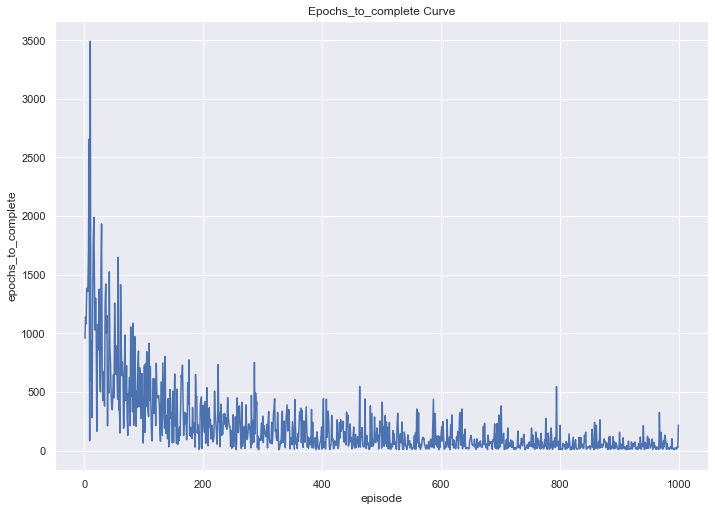

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns_plot = sns.lineplot(x='episode', y='epochs_to_complete',data = learning_df[learning_df.episode<1000]).set(title='Epochs_to_complete Curve')

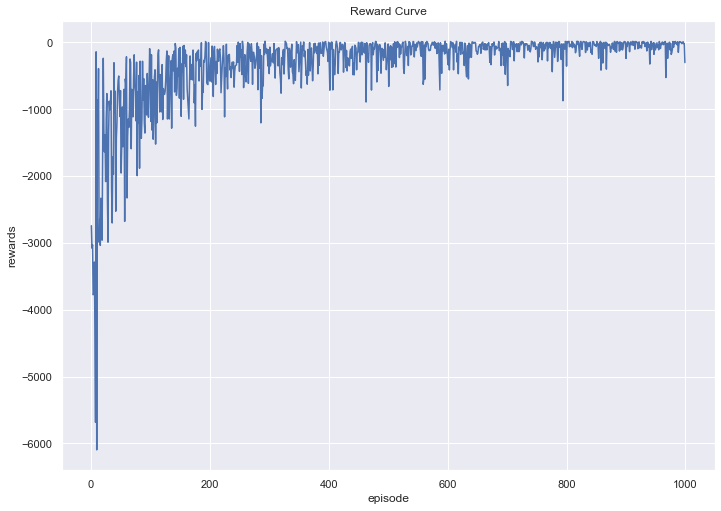

In [22]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns_plot = sns.lineplot(x='episode', y='rewards',data = learning_df[learning_df.episode<1000]).set(title='Reward Curve')

In [23]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print("Results after {} episodes:".format(episodes))
print("Average timesteps per episode: {}".format(total_epochs / episodes))
print("Average penalties per episode: {}".format(total_penalties / episodes))


Results after 100 episodes:
Average timesteps per episode: 13.48
Average penalties per episode: 0.0


In [29]:
env.s = 512  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation
rewards = []

done = False

while not done:
    action = np.argmax(q_table[state])
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )
    rewards.append(reward)
    
    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 14
Penalties incurred: 0


In [32]:
print_frames(frames)

+---------------+
|R: | : :G: : : |
| : | : : : : : |
| : : : : : : : |
| | : | : : : : |
|Y| : |B: : : : |
| : : : : : : : |
| : : : : : : : |
| : : : : : : : |
+---------------+
  (Dropoff)

Timestep: 14
State: 0
Action: 5
Reward: 20
